<a href="https://colab.research.google.com/github/mikeortiz5190/Basic-Portfolio/blob/master/PINN_Navier_stokes_with_airfoil_steady.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time
from itertools import product, combinations

np.random.seed(1234)
tf.set_random_seed(1234)

class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x, y, u, v, layers):
        
        X = np.concatenate([x, y], 1)
        
        # The lower and uper bounds are based off the min and max of np.concatenate([x, y])
        self.lb = X.min(0)
        self.ub = X.max(0)
        print(self.lb)
        print(self.ub)
                
        self.X = X
        
        self.x = X[:,0:1]
        self.y = X[:,1:2]
        
        self.u = u
        self.v = v
        
        self.layers = layers
        
        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers)        
        
        # Initialize parameters
        self.lambda_1 = tf.Variable([0.0], dtype=tf.float32)
        self.lambda_2 = tf.Variable([0.0], dtype=tf.float32)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.y_tf = tf.placeholder(tf.float32, shape=[None, self.y.shape[1]])
        
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
        self.v_tf = tf.placeholder(tf.float32, shape=[None, self.v.shape[1]])

        # L-BFGS-B is a gradient decent model
        # The loss function is the objective function that needs to be minimized
        # The Loss function (objective F) is minimized on each iteration in the self.train fucntion below  

        # Make note that net_NS is passed through this line, why?
        self.u_pred, self.v_pred, self.p_pred, self.f_u_pred, self.f_v_pred = self.net_NS(self.x_tf, self.y_tf)
        
        ########################## LOSS FUNCTION ##############################################
        self.loss = tf.reduce_sum(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_sum(tf.square(self.v_tf - self.v_pred)) + \
                    tf.reduce_sum(tf.square(self.f_u_pred)) + \
                    tf.reduce_sum(tf.square(self.f_v_pred)) 

        #The loss function is passed into both the Adam and L-BFGS-B optimizers, why?
        #because the net loos will be back propogated through the nn via Tensor Flow
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 10000,
                                                                           'maxfun': 10000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        
        
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

        self.count = 0

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        print('initial weights:')
        print(weights)
        print('initial biases:')
        print(biases)  
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        #tf.Variable(tf.truncated_normal([number of inputs, number of outputs], The standard deviation of the normal distribution, before truncation.), dtype=tf.float32)
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    ####### This is the Neural Network Architecture (Navier Stokes model) ###################
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        #Here we build our hidden layers
        # W are the weights
        # b are the biasies
        # H is transformed into the tanh activation function - convolutional network
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0 #spacial components are normalized
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        ###### The output Y of the PINN CONTAINS the Pressure AND POTENTIAL FUNCTION**** ###########
        return Y

 
        
    def net_NS(self, x, y):
        lambda_1 = self.lambda_1
        lambda_2 = self.lambda_2
        
        psi_and_p = self.neural_net(tf.concat([x,y], 1), self.weights, self.biases)
        ##### P AND the POTENTIAL FUNCTION is taken from the output of the PINN ####
        psi = psi_and_p[:,0:1]
        p = psi_and_p[:,1:2]
        
        u = tf.gradients(psi, y)[0]
        v = -tf.gradients(psi, x)[0]  
        
        u_x = tf.gradients(u, x)[0]
        u_y = tf.gradients(u, y)[0]
        u_xx = tf.gradients(u_x, x)[0]
        u_yy = tf.gradients(u_y, y)[0]
        
        v_x = tf.gradients(v, x)[0]
        v_y = tf.gradients(v, y)[0]
        v_xx = tf.gradients(v_x, x)[0]
        v_yy = tf.gradients(v_y, y)[0]
        
        p_x = tf.gradients(p, x)[0]
        p_y = tf.gradients(p, y)[0]

        #########################


        #Use Navier-Stokes to predict the constants lambda_1 & lambda_2 & Pressure

        #lambda_1 = density
        #lambda_2 = dynamic viscosity mu

        ##################################################################


        f_u =  lambda_1*(u*u_x + v*u_y) + p_x - lambda_2*(u_xx + u_yy) 
        f_v =  lambda_1*(u*v_x + v*v_y) + p_y - lambda_2*(v_xx + v_yy)

        ##################################################################

        return u, v, p, f_u, f_v
    
    def callback(self, loss, lambda_1, lambda_2):
        print('Loss: %.3e, l1: %.3f, l2: %.5f' % (loss, lambda_1, lambda_2))
        count = self.count
        print(count)
        self.count +=1
      
    def train(self, nIter): 

        tf_dict = {self.x_tf: self.x, self.y_tf: self.y,
                   self.u_tf: self.u, self.v_tf: self.v}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                lambda_1_value = self.sess.run(self.lambda_1)
                lambda_2_value = self.sess.run(self.lambda_2)
                print('It: %d, Loss: %.3e, l1: %.3f, l2: %.5f, Time: %.2f' % 
                      (it, loss_value, lambda_1_value, lambda_2_value, elapsed))
                start_time = time.time()

        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss, self.lambda_1, self.lambda_2],
                                loss_callback = self.callback)

    # its predicting U, V, and P by predicing Psi and both lambda's first
    def predict(self, x_star, y_star):
        
        tf_dict = {self.x_tf: x_star, self.y_tf: y_star}
        
        u_star = self.sess.run(self.u_pred, tf_dict)
        v_star = self.sess.run(self.v_pred, tf_dict)
        p_star = self.sess.run(self.p_pred, tf_dict)
        
        return u_star, v_star, p_star



In [3]:
################### Training parameters ###################

    
layers = [2, 25,25,25,25,25, 2]
    
# Load Data
#pressure_data='../content/drive/MyDrive/EAS6277-Airfoil-data/pressure_naca0012_5_hybrid.csv'
#velocity_data='../content/drive/MyDrive/EAS6277-Airfoil-data/velocity_naca0012_5_hybrid.csv'

###################################### density=1 visc=1 #######################################
velocity_data='../content/drive/MyDrive/EAS6277-Airfoil-data/T49-T50/airfoil_1_Transient_t50_velocity.csv'
pressure_data='../content/drive/MyDrive/EAS6277-Airfoil-data/T49-T50/airfoil_1_Transient_t50_pressure.csv'
##############################################################################################
import csv

x_offset = 2
y_offset = 3

pressure=[]
xp=[]
yp=[]
p=[]
with open(pressure_data, 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    count = 2
    for row in csvreader:
      if count%2==0:
        xp.append(float(row[0])+ x_offset)
        yp.append(float(row[1])+ y_offset)
        p.append(float(row[3]))
        #count+=1
      else:
        count+=1
pressure.append([xp, yp, p])

velocity=[]
xv=[]
yv=[]
vel_x=[]
vel_y=[]

with open(velocity_data, 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    count = 2
    for row in csvreader:
      if count%2==0:
        xv.append(float(row[0])+ x_offset)
        yv.append(float(row[1])+ y_offset)
        vel_x.append(float(row[3]))
        vel_y.append(float(row[4]))
        #count+=1
      else:
        count+=1
velocity.append([xv, yv, vel_x, vel_y])

################## NORMALIZATION OF VELOCITY ####################
maxvaluex=np.max(velocity[0][2])
maxvaluey=np.max(velocity[0][3])


for i in range(len(velocity[0][2])):
  velocity[0][2][i]=(velocity[0][2][i])/50
  velocity[0][3][i]=(velocity[0][3][i])/50

##################################################################

n = len(velocity[0][0])

x = np.array(velocity[0][0]).reshape(n,1)
y = np.array(velocity[0][1]).reshape(n,1)
u = np.array(velocity[0][2]).reshape(n,1)
v = np.array(velocity[0][3]).reshape(n,1)
p = np.array(pressure[0][2]).reshape(n,1)

import math
percentage_of_data = 1
N_train=math.floor(n/100 *percentage_of_data)
idx = np.random.choice(n, N_train, replace=False)

x_train = x[idx,:]
y_train = y[idx,:]
u_train = u[idx,:]
v_train = v[idx,:]

print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'u_train shape: {u_train.shape}')
print(f'v_train shape: {v_train.shape}')

######################################################################
######################## Number of Data points #######################
######################################################################


x_train shape: (121, 1)
y_train shape: (121, 1)
u_train shape: (121, 1)
v_train shape: (121, 1)


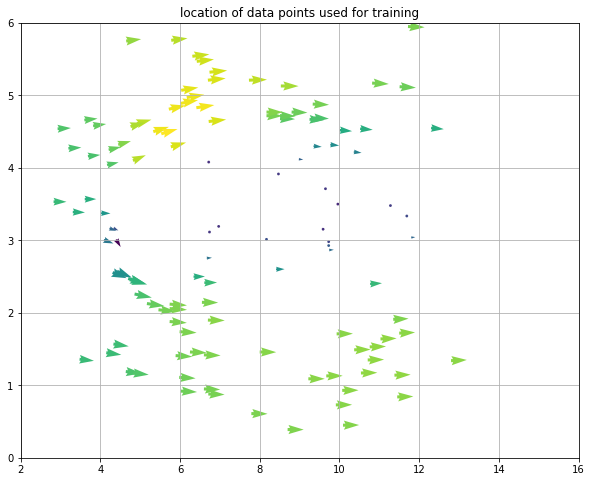

In [4]:
u_test_plot = u_train.reshape(len(u_train))
v_test_plot = v_train.reshape(len(v_train))
x_test_plot = x_train.reshape(len(x_train))
y_test_plot = y_train.reshape(len(y_train))

# Creating arrow
x_pos = x_test_plot
y_pos = y_test_plot
x_direct = u_test_plot
y_direct = v_test_plot

n = -2
color = []
for i in range(len(x_pos)):
    c = np.sqrt(((x_direct[i]-n)/2)*4 + ((y_direct[i]-n)/2)*4)
    color.append(c)
#create plot
fig, ax = plt.subplots(figsize = (10, 8))
ax.quiver(x_pos, y_pos, x_direct, y_direct, color,
         scale = 40)
 
ax.axis([2, 16, 0, 6])
ax.grid()
plt.title("location of data points used for training")
plt.show()

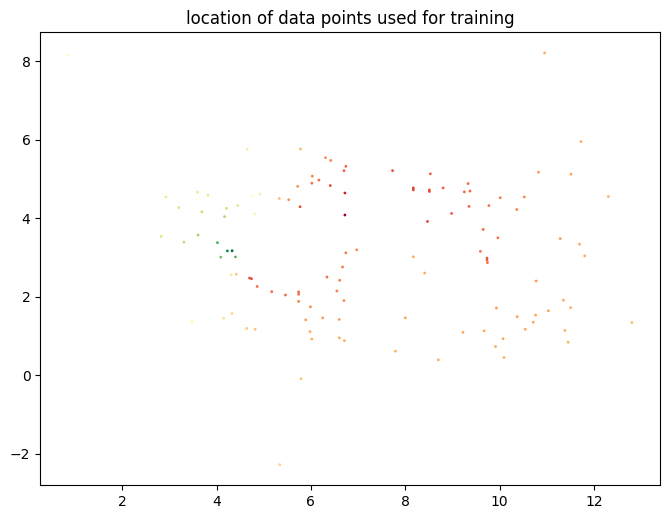

In [5]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=100)
x_test_plot = x_train.reshape(len(x_train))
y_test_plot = y_train.reshape(len(y_train))
q = p[idx,:]
p_test_plot = q.reshape(len(q))
plt.scatter(x_test_plot, y_test_plot, c=p_test_plot, cmap="RdYlGn",s=1)
plt.title("location of data points used for training")
plt.show()

In [6]:
model = PhysicsInformedNN(x_train, y_train, u_train, v_train, layers)
model.train(10000)

[ 0.86 -2.28]
[12.8   8.21]
initial weights:
[<tf.Variable 'Variable:0' shape=(2, 25) dtype=float32_ref>, <tf.Variable 'Variable_2:0' shape=(25, 25) dtype=float32_ref>, <tf.Variable 'Variable_4:0' shape=(25, 25) dtype=float32_ref>, <tf.Variable 'Variable_6:0' shape=(25, 25) dtype=float32_ref>, <tf.Variable 'Variable_8:0' shape=(25, 25) dtype=float32_ref>, <tf.Variable 'Variable_10:0' shape=(25, 2) dtype=float32_ref>]
initial biases:
[<tf.Variable 'Variable_1:0' shape=(1, 25) dtype=float32_ref>, <tf.Variable 'Variable_3:0' shape=(1, 25) dtype=float32_ref>, <tf.Variable 'Variable_5:0' shape=(1, 25) dtype=float32_ref>, <tf.Variable 'Variable_7:0' shape=(1, 25) dtype=float32_ref>, <tf.Variable 'Variable_9:0' shape=(1, 25) dtype=float32_ref>, <tf.Variable 'Variable_11:0' shape=(1, 2) dtype=float32_ref>]
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0

In [7]:
# Test Data

x_star = x
y_star = y
    
u_star = u
v_star = v
p_star = p
    
# Prediction from model
u_pred, v_pred, p_pred = model.predict(x_star, y_star)
#extract lamda 1 and lmabda 2 from model
lambda_1_value = model.sess.run(model.lambda_1)
lambda_2_value = model.sess.run(model.lambda_2)


           

In [8]:
# Error
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)*100
error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)*100
error_p = np.linalg.norm(p_star-p_pred,2)/np.linalg.norm(p_star,2)*100

error_lambda_1 = np.abs(lambda_1_value - 1.0)*100
error_lambda_2 = np.abs(lambda_2_value - 1.0)*100
    
print('Error u: %e' % (error_u) +'%')    
print('Error v: %e' % (error_v) +'%')    
print('Error p: %e' % (error_p) +'%')   
print('Error Density: %.5f%%' % (error_lambda_1))                             
print('Error Dynamic viscosity: %.5f%%' % (error_lambda_2))  

Error u: 6.919749e+00%
Error v: 3.016046e+01%
Error p: 1.000022e+02%
Error Density: 99.97546%
Error Dynamic viscosity: 100.00182%


In [11]:
######################################################################
############################# Plotting ###############################
######################################################################  

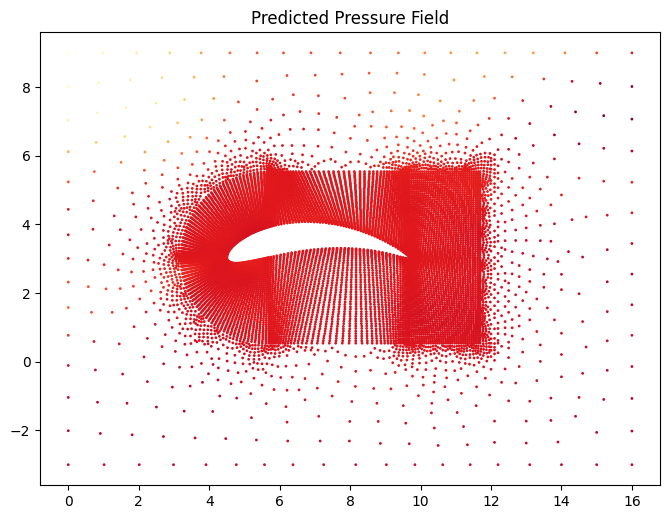

In [9]:
figure(figsize=(8, 6), dpi=100)
x_test_plot = x.reshape(len(x))
y_test_plot = y.reshape(len(y))
pred_pressure = list(p_pred.reshape(len(p_pred)))
plt.scatter(x_test_plot, y_test_plot, c=pred_pressure, cmap="YlOrRd",s=1)
plt.title("Predicted Pressure Field")
plt.show()

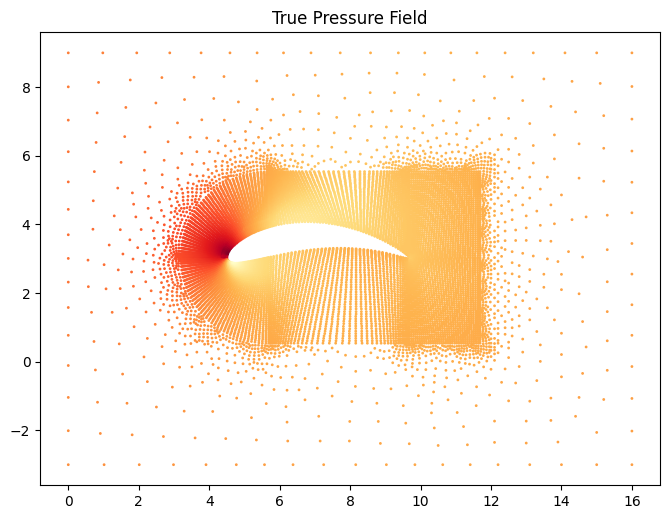

In [10]:
figure(figsize=(8, 6), dpi=100)
x_test_plot = x.reshape(len(x))
y_test_plot = y.reshape(len(y))
pressure_T = list(p.reshape(len(p)))
plt.scatter(x_test_plot, y_test_plot, c=pressure_T, cmap="YlOrRd" ,s=1)
plt.title("True Pressure Field")
plt.show()

Text(0.5, 1.0, 'Prediected Velocity Field')

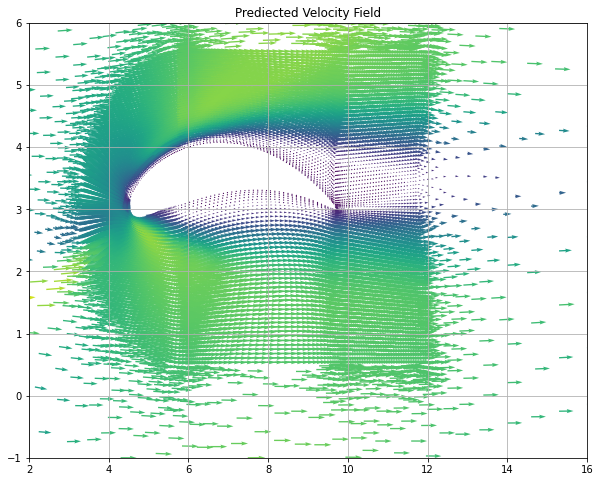

In [11]:
# Creating arrow
x_pos = x_test_plot
y_pos = y_test_plot
x_direct1 = list(u_pred.reshape(len(u_pred)))
y_direct1 = list(v_pred.reshape(len(v_pred)))

color = []
for i in range(len(x_pos)):
    c = np.sqrt((x_direct1[i]**2) + (y_direct1[i]**2))
    color.append(c)
#create plot
fig, ax = plt.subplots(figsize = (10, 8))
ax.quiver(x_pos, y_pos, x_direct1, y_direct1, color,
         scale = 40)
 
ax.axis([2, 16, -1, 6])
ax.grid() 
plt.title('Prediected Velocity Field')
# show plot

Text(0.5, 1.0, 'True Velocity Field')

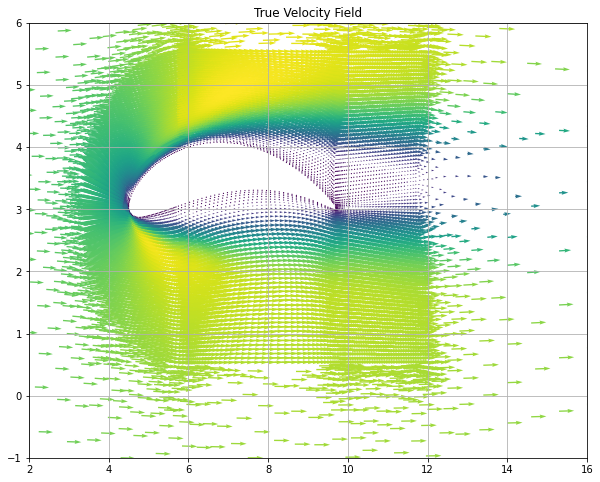

In [12]:
# Creating arrow
x_pos = x_test_plot
y_pos = y_test_plot
x_direct = list(u.reshape(len(u)))
y_direct = list(v.reshape(len(v)))

color = []
for i in range(len(x_pos)):
    c = np.sqrt((x_direct[i]**2) + (y_direct[i]**2))
    color.append(c)
#create plot
fig, ax = plt.subplots(figsize = (10, 8))
ax.quiver(x_pos, y_pos, x_direct, y_direct, color,
         scale = 40)
 
ax.axis([2, 16, -1, 6])
ax.grid()
plt.title('True Velocity Field')
# show plot

In [17]:
##############################################################################################
pressure_data='../content/drive/MyDrive/EAS6277-Airfoil-data/T49-T50/airfoil_1_Transient_t50_pressure_at_Wing.csv'
p_wing_Sim=[]
x_wing=[]
y_wing=[]
lift_Sim = []
drag_Sim = []
with open(pressure_data, 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    count=2
    for row in csvreader:
      if count%2==0:
        x_wing.append(float(row[0])+x_offset)
        y_wing.append(float(row[1])+y_offset)
        p_wing_Sim.append(float(row[3]))
        count+=1
      else:
        count+=1

for i in range(len(p_wing_Sim)-1):
  lift_Sim.append(-0.5*(p_wing_Sim[i+1] + p_wing_Sim[i])*1.2e-2*abs(x_wing[i+1]-x_wing[i]))
  drag_Sim.append(-0.5*(p_wing_Sim[i+1] + p_wing_Sim[i])*1.2e-2*abs(y_wing[i+1]-y_wing[i]))

# total area
displ = 0
for i in range(len(p_wing_Sim)-1):
  displ += np.sqrt((x_wing[i+1]-x_wing[i])**2 + (y_wing[i+1]-y_wing[i])**2)


lift_force_Sim = np.sum(lift_Sim)
drag_force_Sim = np.sum(drag_Sim)

Cl_Sim = 2*lift_force_Sim / (1 * 50**2 * (displ*1.2e-2))
Cd_Sim = 2*drag_force_Sim / (1 * 50**2 * (displ*1.2e-2))

print(f'Lift Cl for Sim: {Cl_Sim}, Drag Cd for Sim: {Cd_Sim}')


Lift Cl for Sim: 0.23225834348622876, Drag Cd for Sim: 0.008002968158352837


In [18]:
##############################################################################################
Free_stream_norm_velocity = 50/maxvaluex

n = len(x_wing)
x_PINN = np.array(x_wing).reshape(n,1)
y_PINN = np.array(y_wing).reshape(n,1)
u_pred_PINN, v_pred_PINN, p_wing_PINN = model.predict(x_PINN, y_PINN)
p_wing_PINN = p_wing_PINN.reshape(n)

lift_PINN = []
drag_PINN = []


for i in range(len(p_wing_PINN)-1):
  lift_PINN.append(-0.5*(p_wing_PINN[i+1] + p_wing_PINN[i])*1.2e-2*abs(x_wing[i+1]-x_wing[i]))
  drag_PINN.append(-0.5*(p_wing_PINN[i+1] + p_wing_PINN[i])*1.2e-2*abs(y_wing[i+1]-y_wing[i]))


lift_force_PINN = np.sum(lift_PINN)
drag_force_PINN = np.sum(drag_PINN)

Cl_PINN = 2*lift_force_PINN / (1 * Free_stream_norm_velocity**2 * (displ*1.2e-2))
Cd_PINN = 2*drag_force_PINN / (1 * Free_stream_norm_velocity**2 * (displ*1.2e-2))

print(f'Lift Cl for PINN: {Cl_PINN}, Drag Cd for PINN: {Cd_PINN}')

Lift Cl for PINN: 0.06571967796055657, Drag Cd for PINN: 0.006147957432274031


In [19]:
print(f'Lift Cl Error: {100*abs(Cl_PINN-Cl_Sim)/Cl_Sim}% , Drag Cd Error: {100*abs(Cd_PINN-Cd_Sim)/Cd_Sim}%')

Lift Cl Error: 71.70406153161372% , Drag Cd Error: 23.179034195490324%


In [20]:
from csv import writer

for i in range(len(p1)):
  x=list(p1[i])
  with open('../content/drive/MyDrive/1-NS_files/Pressure_data.csv', 'a', newline='') as f_object:  
    # Pass the CSV  file object to the writer() function
    writer_object = writer(f_object)
    # Result - a writer object
    # Pass the data in the list as an argument into the writerow() function
    writer_object.writerow(x)  
    # Close the file object
    f_object.close()


NameError: ignored